# Triton Inference Server Simple Test

In [11]:
import json
import numpy as np
import tritonclient.http as httpclient
import tritonclient.grpc as grpcclient
from utils.inference_lib import encode_image, decode_image
    
def setup_triton_httpclient(url="localhost"):

    try:
        triton_client = httpclient.InferenceServerClient(
            url=f"{url}:8000",
            verbose=False,
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def setup_triton_grpcclient(url="localhost"):

    try:
        triton_client = grpcclient.InferenceServerClient(
            url=f"{url}:8001",
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def get_sample_binary_httpclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(httpclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(httpclient.InferRequestedOutput("generated_image", binary_data=True))

    return inputs, outputs


def get_sample_binary_grpcclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(grpcclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(grpcclient.InferRequestedOutput("generated_image"))

    return inputs, outputs

<br>

## 1. httpclient
---

### Initializt triton client

In [7]:
triton_client = setup_triton_httpclient()

### Prepare input data

In [16]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

inputs, outputs = get_sample_binary_httpclient(payload)

### Inference

CPU times: user 0 ns, sys: 1.82 ms, total: 1.82 ms
Wall time: 2.71 s


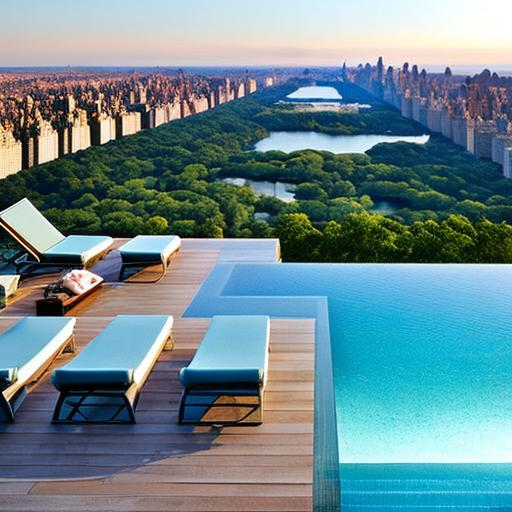

In [17]:
%%time
model_name = "sd_base"
results = triton_client.infer(
    model_name,
    inputs,
    outputs=outputs,
    headers=None
)

output_image = results.as_numpy('generated_image')
decode_image(output_image[0].decode('utf-8'))

<br>

## 2. grpcclient
---

### Initializt triton client

In [18]:
triton_client = setup_triton_grpcclient()

### Prepare input data

In [19]:
inputs, outputs = get_sample_binary_grpcclient(payload)

### Inference

CPU times: user 0 ns, sys: 2.91 ms, total: 2.91 ms
Wall time: 2.71 s


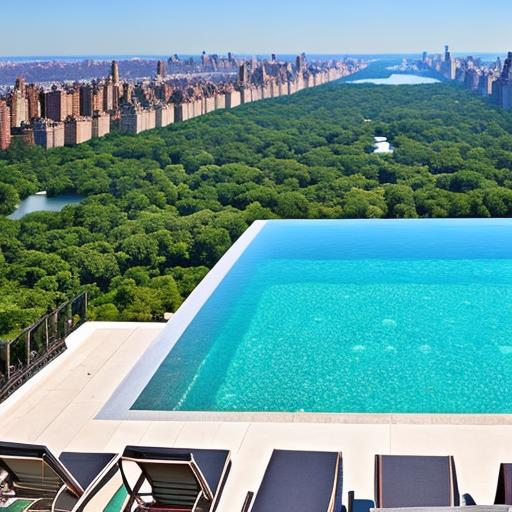

In [20]:
%%time
model_name = "sd_base"
results = triton_client.infer(
    model_name,
    inputs,
    outputs=outputs,
    headers=None
)

output_image = results.as_numpy('generated_image')
decode_image(output_image[0].decode('utf-8'))